In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from sklearn.exceptions import ConvergenceWarning
from sklearn import model_selection, preprocessing, metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
import time
import xgboost as xgb
import csv
import seaborn as sns 
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import prince

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [17]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')
ENSEMBLE_PATH = os.path.join(DATA_PATH, 'ensemble/malhotra')
JULY7_PATH = os.path.join(DATA_PATH, 'july7.csv')
JULY9_PATH = os.path.join(DATA_PATH, 'july9.csv')

In [18]:
train_df = pd.read_csv(TRAIN_DATA)
train_outlier_df = pd.read_csv('https://raw.githubusercontent.com/JovanSardinha/mercedes-benz-greener-manufacturing/master/mercedes-benz-greener-manufacturing/assets/train_outlier_list.csv?token=ABDAkaZcaPJIU4mIOHyS7OIEASEV6ADQks5ZZ-29wA%3D%3D')
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)
print('train_df.shape', train_df.shape)
print('train_outlier_df.shape', train_outlier_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (4209, 378)
train_outlier_df.shape (4209, 11)
test_df.shape (4209, 377)


In [19]:
magic_df = pd.read_csv(JULY7_PATH)
magic_df = magic_df.rename(columns={'median(y)': 'median_y'})
magic_df = magic_df[['G', 'X0', 'X118', 'X127', 'n', 'median_y']]
pred_df = pd.merge(train_df, magic_df, on=['X0', 'X118', 'X127'], how='left')[['y', 'median_y']]
r2 = metrics.r2_score(pred_df.y.values, pred_df.median_y.values)
print('R2 score for july7.csv', r2)

R2 score for july7.csv 0.540705721052


In [20]:
magic_df = pd.read_csv(JULY9_PATH)
magic_df = magic_df.rename(columns={'median(y)': 'median_y'})
magic_df = magic_df[['G', 'X0', 'X118', 'X127', 'n', 'median_y']]
magic_df = magic_df[~magic_df.G.isnull()]
magic_df['X118'] = magic_df['X118'].astype(int)
magic_df['X127'] = magic_df['X127'].astype(int)
pred_df = pd.merge(train_df, magic_df, on=['X0', 'X118', 'X127'], how='left')
r2 = metrics.r2_score(pred_df.y.values, pred_df.median_y.values)
print('R2 score for july9.csv', r2)

R2 score for july9.csv 0.540705721052


In [21]:
train_df_id_idx = train_df.set_index(['ID'], drop=True)
df = train_df_id_idx.drop(['y'], axis=1).duplicated(keep=False)
dupes_X = train_df_id_idx.drop(['y'], axis=1)[df]
dupe_ids = dupes_X.index.values
dupes = train_df_id_idx[train_df_id_idx.index.isin(dupe_ids)]
train_columns = list(set(dupes.columns) - set(['ID', 'y']))
mean_y = dupes.groupby(train_columns).y.mean().reset_index().rename(columns={'y':'mean_y'})
median_y = dupes.groupby(train_columns).y.median().reset_index().rename(columns={'y':'median_y'})
variance_y = dupes.groupby(train_columns).y.var().reset_index().rename(columns={'y':'variance_y'})
std_y = dupes.groupby(train_columns).y.std().reset_index().rename(columns={'y':'std_y'})
temp = pd.merge(dupes, mean_y, on=train_columns, how='left')
temp = pd.merge(temp, median_y, on=train_columns, how='left')
temp = pd.merge(temp, variance_y, on=train_columns, how='left')
temp = pd.merge(temp, std_y, on=train_columns, how='left')
result = temp.sort_index().sort_values(train_columns)
result['residual_y'] = result.y - result.mean_y
counts = dupes.groupby(train_columns).y.agg('count').reset_index().rename(columns={'y':'counts'})
result.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X380,X382,X383,X384,X385,mean_y,median_y,variance_y,std_y,residual_y
11,95.57,y,v,ai,c,d,j,g,l,0,...,0,0,0,0,0,101.196667,95.57,234.574933,15.315839,-5.626667
13,118.53,y,v,ai,c,d,j,g,l,0,...,0,0,0,0,0,101.196667,95.57,234.574933,15.315839,17.333333
22,89.49,y,v,ai,c,d,j,g,l,0,...,0,0,0,0,0,101.196667,95.57,234.574933,15.315839,-11.706667
478,88.28,al,o,ai,f,d,w,j,p,0,...,0,0,0,0,0,99.690000,99.69,260.376200,16.136177,-11.410000
499,111.10,al,o,ai,f,d,w,j,p,0,...,0,0,0,0,0,99.690000,99.69,260.376200,16.136177,11.410000


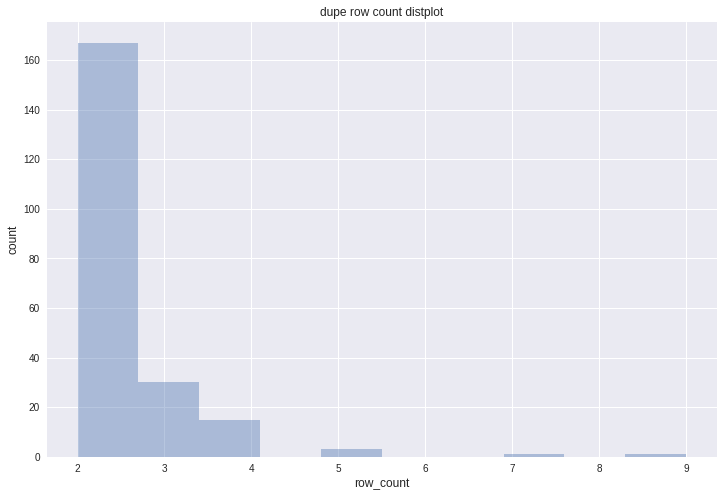

In [16]:
plt.figure(figsize=(12,8))
sns.distplot(counts.counts.values, bins=10, kde=False)
plt.xlabel('row_count', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('dupe row count distplot')
plt.show()

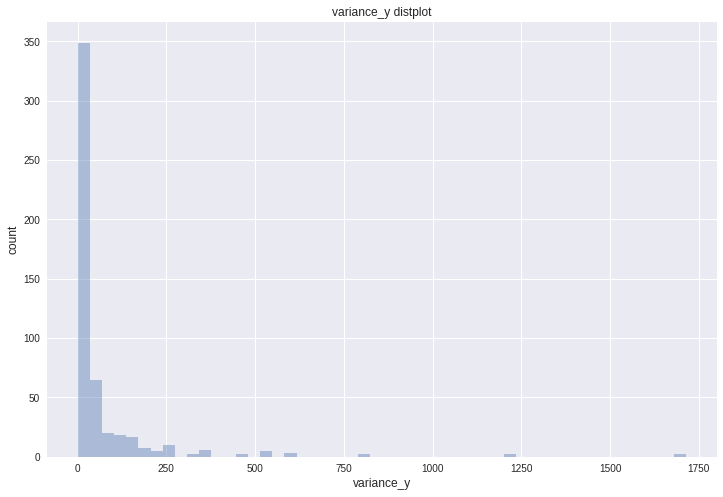

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(result.variance_y.values, bins=50, kde=False)
plt.xlabel('variance_y', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('variance_y distplot')
plt.show()

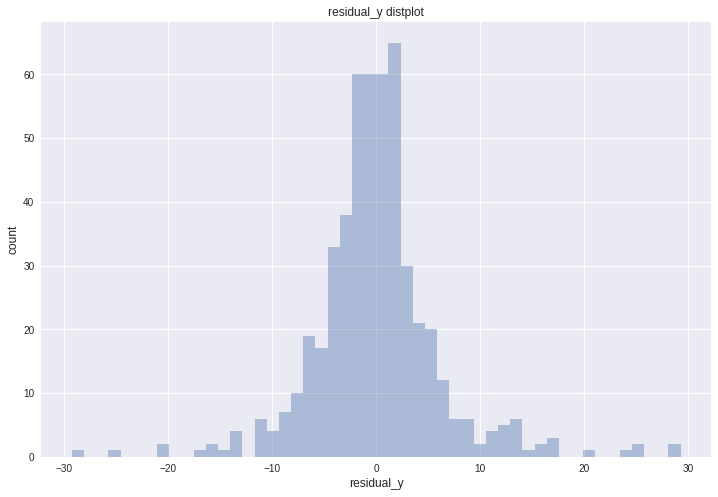

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(result.residual_y.values, bins=50, kde=False)
plt.xlabel('residual_y', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('residual_y distplot')
plt.show()

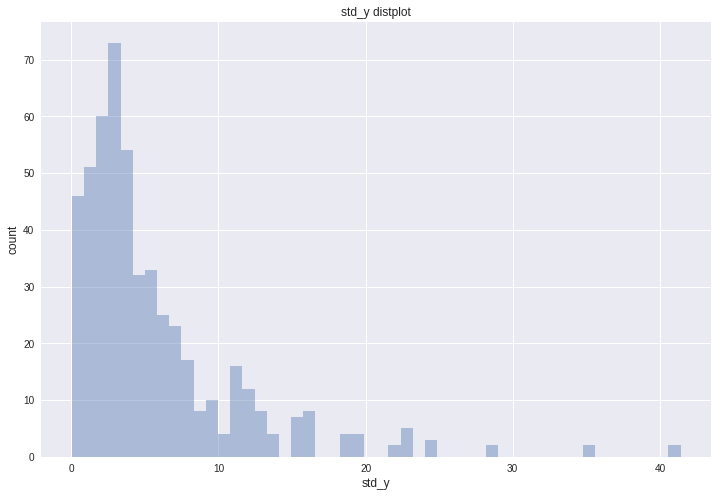

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(result.std_y.values, bins=50, kde=False)
plt.xlabel('std_y', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('std_y distplot')
plt.show()

In [22]:
filter_dupes = False
mean_dupes = True
filter_outliers = True
filter_outliers_2_5 = False
xgb_use_augment_features = True
keep_ID = True
add_magic_feature = True
one_hot_features = False
add_G = True

if filter_dupes:
    print('Filtering dupes')
    train_df = train_df[~train_df.ID.isin(dupe_ids)]
elif mean_dupes:
    print('Taking mean of y for dupes')   
    temp2 = pd.merge(train_df, mean_y, on=train_columns, how='left')
    temp2.loc[temp2.mean_y.notnull(), 'y'] = temp2[temp2.mean_y.notnull()].mean_y
    temp2 = temp2.drop('mean_y', axis=1)
    train_df = temp2.drop_duplicates(subset=train_columns, keep='last')

if filter_outliers:
    print('Filtering outliers')
    # Filter out outlier y = 265.32
    train_df = train_df[train_df.y < 200]

if add_G:
    magic_df = pd.read_csv(JULY9_PATH)
    magic_df = magic_df.rename(columns={'median(y)': 'median_y'})
    magic_df = magic_df[['G', 'X0', 'X118', 'X127']]
    magic_df = magic_df[~magic_df.G.isnull()]
    magic_df['X118'] = magic_df['X118'].astype(int)
    magic_df['X127'] = magic_df['X127'].astype(int)
    pred_df = pd.merge(train_df, magic_df, on=['X0', 'X118', 'X127'], how='left')
    train_df = pred_df
    print('Added G column to train_df')
    
    magic_df = pd.read_csv(JULY9_PATH)
    magic_df = magic_df.rename(columns={'median(y)': 'median_y'})
    magic_df = magic_df[['G', 'X0', 'X118', 'X127']]
    magic_df = magic_df[~magic_df.G.isnull()]
    magic_df['X118'] = magic_df['X118'].astype(int)
    magic_df['X127'] = magic_df['X127'].astype(int)
    pred_df = pd.merge(test_df, magic_df, on=['X0', 'X118', 'X127'], how='left')
    test_df = pred_df
    print('Added G column to test_df')
    
# Preprocess data
print('Dropping constant value columns')
for column in train_df.columns:
    cardinality = len(np.unique(train_df[column]))
    if cardinality == 1:
        train_df.drop(column, axis=1, inplace=True)
        test_df.drop(column, axis=1, inplace=True)

original_train_columns = sorted(list(set(train_df.columns) - set(['ID', 'y'])))

if one_hot_features:
    all_data = pd.concat((train_df, test_df))
    numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
    categorical_feats = all_data.dtypes[all_data.dtypes == 'object'].index
    print('One hot encoding categorical features')
    for i, col_name in enumerate(categorical_feats):
        print(' Converting %s' % col_name)
        temp_df = pd.get_dummies(all_data[col_name])
        new_features = temp_df.columns.tolist()
        new_features = [col_name + '_' + w for w in new_features]
        temp_df.columns = new_features
        all_data.drop(col_name, axis=1, inplace=True)
        all_data = pd.concat((all_data, temp_df), axis=1)
    train_df = all_data[:train_df.shape[0]]
    test_df = all_data[train_df.shape[0]:]
    test_df = test_df.drop(['y'], axis=1)
else:
    for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8", "G"]:
        lbl = preprocessing.LabelEncoder()
        train_values = set(train_df[f].values)
        test_values = set(test_df[f].values)
        all_values = list(train_values | test_values)
        lbl.fit(all_values) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

if xgb_use_augment_features:
    n_comp = 10
    
    # PCA
    pca = PCA(n_components=n_comp, random_state=420)
    pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
    pca2_results_test = pca.transform(test_df)

    # ICA
    ica = FastICA(n_components=n_comp, random_state=420)
    ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
    ica2_results_test = ica.transform(test_df)

    # GRP
    grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
    grp_results_train = grp.fit_transform(train_df.drop(["y"], axis=1))
    grp_results_test = grp.transform(test_df)

    # SRP
    srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
    srp_results_train = srp.fit_transform(train_df.drop(["y"], axis=1))
    srp_results_test = srp.transform(test_df)
    
    #mca = prince.MCA(train_df.drop(["y"], axis=1), n_components=n_comp)
    
    # Append decomposition components to datasets
    for i in range(0, n_comp):
        train_df['pca_' + str(i)] = pca2_results_train[:, i]
        test_df['pca_' + str(i)] = pca2_results_test[:, i]

        train_df['ica_' + str(i)] = ica2_results_train[:, i]
        test_df['ica_' + str(i)] = ica2_results_test[:, i]
        
        train_df['grp_' + str(i)] = grp_results_train[:, i]
        test_df['grp_' + str(i)] = grp_results_test[:, i]
        
        train_df['srp_' + str(i)] = srp_results_train[:, i]
        test_df['srp_' + str(i)] = srp_results_test[:, i]
        
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

Taking mean of y for dupes
Filtering outliers
Added G column to train_df
Added G column to test_df
Dropping constant value columns
train_df.shape (3910, 407)
test_df.shape (4209, 406)


In [23]:
if keep_ID:
    print('Keeping ID in training columns')
    X = train_df.drop(['y'], axis=1)
    test_X = test_df
else:
    X = train_df.drop(["y"], axis=1).set_index(['ID'], drop=True)
    test_X = test_df.set_index(['ID'], drop=True)

Y = train_df['y'].values

print('X.shape', X.shape)
print('Y.shape', Y.shape)

if add_magic_feature:    
    temp_X = X.copy()
    temp_X['y'] = Y
    median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
    test_X_median_df = pd.merge(test_X, median_df, on='X0', how='left')
    test_X_median_df.loc[test_X_median_df.median_y.isnull(), 'median_y'] = Y.mean()
    test_X = test_X_median_df
    test_X = test_X.set_index(test_df.ID.values)
    test_X.index.name = 'ID'
    print('test_X.shape', test_X.shape)

Keeping ID in training columns
X.shape (3910, 406)
Y.shape (3910,)
test_X.shape (4209, 407)


In [24]:
NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

dataset_blend_train1 = np.zeros((X.shape[0]))
dataset_blend_test1 = np.zeros((test_X.shape[0]))
dataset_blend_test_j = np.zeros((test_X.shape[0], NUM_FOLDS))

for fold, (train_idxs, val_idxs) in enumerate(kf.split(X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = X.iloc[train_idxs], X.iloc[val_idxs]
    trn_Y, val_Y = Y[train_idxs], Y[val_idxs]
    
    mean_Y = trn_Y.mean()
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df
    
    if filter_outliers_2_5:
        train_outlier_ids = train_outlier_df.loc[train_outlier_df['is_outlier_2-5'] == 1, 'ID'].tolist()
        trn_X = trn_X.loc[~trn_X.ID.isin(train_outlier_ids)]
        trn_Y = trn_Y[np.where(~trn_X.ID.isin(train_outlier_ids) == True)]
        #val_X = val_X.loc[~val_X.ID.isin(train_outlier_ids)]

    def xgb_r2_score(preds, dtrain):
        labels = dtrain.get_label()
        return 'rmse', -1.0 * metrics.r2_score(labels, preds)

    model = xgb.XGBRegressor(max_depth = 10,
                        objective="reg:linear",
                        n_estimators=1500,
                        learning_rate=0.0045,
                        nthread=12,
                        subsample=0.93,
                        base_score=mean_Y,
                        seed=42,
                        silent=True)

    model.fit(trn_X, trn_Y, eval_set=[(trn_X, trn_Y), (val_X, val_Y)], verbose=False, eval_metric='rmse', early_stopping_rounds=50)
    evals_result = model.evals_result()
    pickle.dump(model, open(os.path.join(MODELS_PATH, model_id + ".xgb"), "wb"))
    
    trn_Y_pred = model.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    train_var = np.var(trn_Y_pred)
    train_mae = metrics.mean_absolute_error(trn_Y, trn_Y_pred)
    
    val_Y_pred = model.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    val_var = np.var(val_Y_pred)
    val_mae = metrics.mean_absolute_error(val_Y, val_Y_pred)
    
    test_Y_pred = model.predict(test_X)
    dataset_blend_train1[val_idxs] = val_Y_pred
    dataset_blend_test_j[:, fold] = model.predict(test_X)
    
    perf.append((fold, model_id, train_r2_score, val_r2_score,
                 train_var, val_var,
                 train_mae, val_mae))
dataset_blend_test1 = dataset_blend_test_j.mean(1)

perf_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2',
                                      'train_var', 'validation_var',
                                      'train_mae', 'validation_mae'])

# val_r2_mean = "{:0.5f}".format(perf_df['validation_r2'].mean())[2:]
# ts = str(int(time.time()))

# train_blend_df = pd.DataFrame(data=dataset_blend_train, index=X.index, columns=['y'])
# test_blend_df = pd.DataFrame(data=dataset_blend_test, index=test_X.index, columns=['y'])

# train_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_xgb5fold_{}_{}_{}_train.csv'.format(ts, 0, val_r2_mean)), index=True)
# test_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_xgb5fold_{}_{}_{}_test.csv'.format(ts, 0, val_r2_mean)), index=True)

print('Avg', '\n',
      '   train r2', perf_df['train_r2'].mean(), '\n',
      '   validation r2', perf_df['validation_r2'].mean(), '\n',
      '   train var', perf_df['train_var'].mean(), '\n',
      '   validation var', perf_df['validation_var'].mean(), '\n',
      '   train mae', perf_df['train_mae'].mean(), '\n',
      '   validation mae', perf_df['validation_mae'].mean())
print('Out of fold\n',
      '   train r2', metrics.r2_score(Y, dataset_blend_train1), '\n',
      '   train mae', metrics.mean_absolute_error(Y, dataset_blend_train1))
perf_df

Fold 0 Training model-1499635966
Fold 1 Training model-1499635971
Fold 2 Training model-1499635976
Fold 3 Training model-1499635981
Fold 4 Training model-1499635986
Avg 
    train r2 0.853982469282 
    validation r2 0.573866378384 
    train var 92.4360153198 
    validation var 83.4233428955 
    train mae 3.2786862821 
    validation mae 5.36994942876
Out of fold
    train r2 0.572449680671 
    train mae 5.36994942876


,fold,model_id,train_r2,validation_r2,train_var,validation_var,train_mae,validation_mae
0,0,model-1499635966,0.850665,0.518381,88.647362,81.148834,3.325908,5.713607
1,1,model-1499635971,0.855418,0.578134,93.094009,83.405342,3.243403,5.396031
2,2,model-1499635976,0.837275,0.617677,89.717209,83.365417,3.466114,5.122105
3,3,model-1499635981,0.863624,0.591886,94.460251,83.053978,3.173149,5.234844
4,4,model-1499635986,0.862931,0.563255,96.261246,86.143143,3.184857,5.383160


In [ ]:
# from sklearn.tree import export_graphviz
# from sklearn import tree
# from IPython.display import Image
# from sklearn.externals.six import StringIO
# import pydot
# model = pickle.load(open(os.path.join(MODELS_PATH, 'model-1499283575.xgb'), 'rb'))
# xgb.plot_tree(model)

In [25]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

dataset_blend_train2 = np.zeros((X.shape[0]))
dataset_blend_test2 = np.zeros((test_X.shape[0]))
dataset_blend_test_j = np.zeros((test_X.shape[0], NUM_FOLDS))

for fold, (train_idxs, val_idxs) in enumerate(kf.split(X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = X.iloc[train_idxs], X.iloc[val_idxs]
    trn_Y, val_Y = Y[train_idxs], Y[val_idxs]
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df
    
    stacked_pipeline = make_pipeline(
        StackingEstimator(estimator=LassoLarsCV(normalize=True)),
        StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber",
                                                              n_estimators=500, max_depth=3,
                                                              max_features=0.55, min_samples_leaf=18,
                                                              min_samples_split=14, subsample=0.7)),
        LassoLarsCV())
    stacked_pipeline.fit(trn_X, trn_Y)
    pickle.dump(stacked_pipeline, open(os.path.join(MODELS_PATH, model_id + ".stacked"), "wb"))
   
    trn_Y_pred = stacked_pipeline.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    train_var = np.var(trn_Y_pred)
    train_mae = metrics.mean_absolute_error(trn_Y, trn_Y_pred)
    
    val_Y_pred = stacked_pipeline.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    val_var = np.var(val_Y_pred)
    val_mae = metrics.mean_absolute_error(val_Y, val_Y_pred)
    
    test_Y_pred = model.predict(test_X)
    dataset_blend_train2[val_idxs] = val_Y_pred
    dataset_blend_test_j[:, fold] = model.predict(test_X)
    
    perf.append((fold, model_id, train_r2_score, val_r2_score,
                 train_var, val_var, 
                 train_mae, val_mae))

dataset_blend_test2 = dataset_blend_test_j.mean(1)

perf_stacked_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2',
                                      'train_var', 'validation_var', 
                                      'train_mae', 'validation_mae'])

# val_r2_mean = val_r2_mean = "{:0.5f}".format(perf_stacked_df['validation_r2'].mean())[2:]
# ts = str(int(time.time()))

# train_blend_df = pd.DataFrame(data=dataset_blend_train, index=X.index, columns=['y'])
# test_blend_df = pd.DataFrame(data=dataset_blend_test, index=test_X.index, columns=['y'])

# train_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_stacked5fold_{}_{}_{}_train.csv'.format(ts, 0, val_r2_mean)), index=True)
# test_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_stacked5fold_{}_{}_{}_test.csv'.format(ts, 0, val_r2_mean)), index=True)

print('Avg', '\n',
      '   train r2', perf_stacked_df['train_r2'].mean(), '\n',
      '   validation r2', perf_stacked_df['validation_r2'].mean(), '\n',
      '   train var', perf_stacked_df['train_var'].mean(), '\n',
      '   validation var', perf_stacked_df['validation_var'].mean(), '\n',
      '   train mae', perf_stacked_df['train_mae'].mean(), '\n',
      '   validation mae', perf_stacked_df['validation_mae'].mean())
print('Out of fold\n',
      '   train r2', metrics.r2_score(Y, dataset_blend_train2), '\n',
      '   train mae', metrics.mean_absolute_error(Y, dataset_blend_train2))
perf_stacked_df

Fold 0 Training model-1499635992


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 1 Training model-1499636003


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 2 Training model-1499636014


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 3 Training model-1499636025


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 4 Training model-1499636036


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Avg 
    train r2 0.619656025703 
    validation r2 0.603920847215 
    train var 84.2858135124 
    validation var 83.7255715758 
    train mae 5.05155753402 
    validation mae 5.16144550905
Out of fold
    train r2 0.60241083165 
    train mae 5.16144550905


,fold,model_id,train_r2,validation_r2,train_var,validation_var,train_mae,validation_mae
0,0,model-1499635992,0.635931,0.547472,85.856560,81.796076,4.924544,5.470057
1,1,model-1499636003,0.617428,0.603967,80.485593,82.322583,5.026142,5.259228
2,2,model-1499636014,0.610905,0.642432,85.213294,85.126409,5.114031,4.950390
3,3,model-1499636025,0.606631,0.635767,83.006776,84.717718,5.170704,4.918819
4,4,model-1499636036,0.627384,0.589967,86.866846,84.665071,5.022366,5.208734


In [10]:
weights = [0.75, 0.25]

dataset_blend_test = dataset_blend_test1 * weights[0] + dataset_blend_test2 * weights[1]
dataset_blend_train = dataset_blend_train1 * weights[0] + dataset_blend_train2 * weights[1]

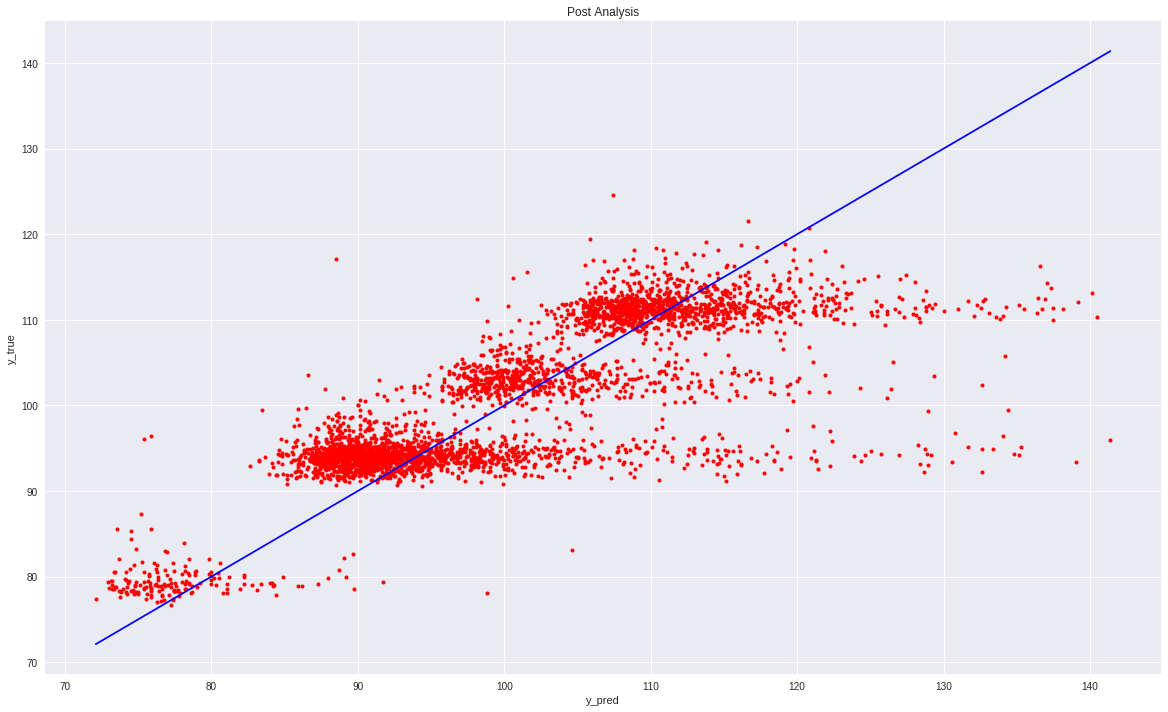

In [11]:
post_analysis = pd.DataFrame()
post_analysis['y_pred'] = dataset_blend_train
post_analysis['y_true'] = Y

lims = [
    np.min([post_analysis.y_pred.values, post_analysis.y_true.values]),  # min of both axes
    np.max([post_analysis.y_pred.values, post_analysis.y_true.values]),  # max of both axes
]

# now plot both limits against eachother
fig, ax1 = plt.subplots(figsize=(20,12))
plt.title('Post Analysis')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.plot(post_analysis.y_true.values, post_analysis.y_pred.values, 'ro', markersize=4.0)
plt.plot(lims, lims, 'b-')

plt.show()

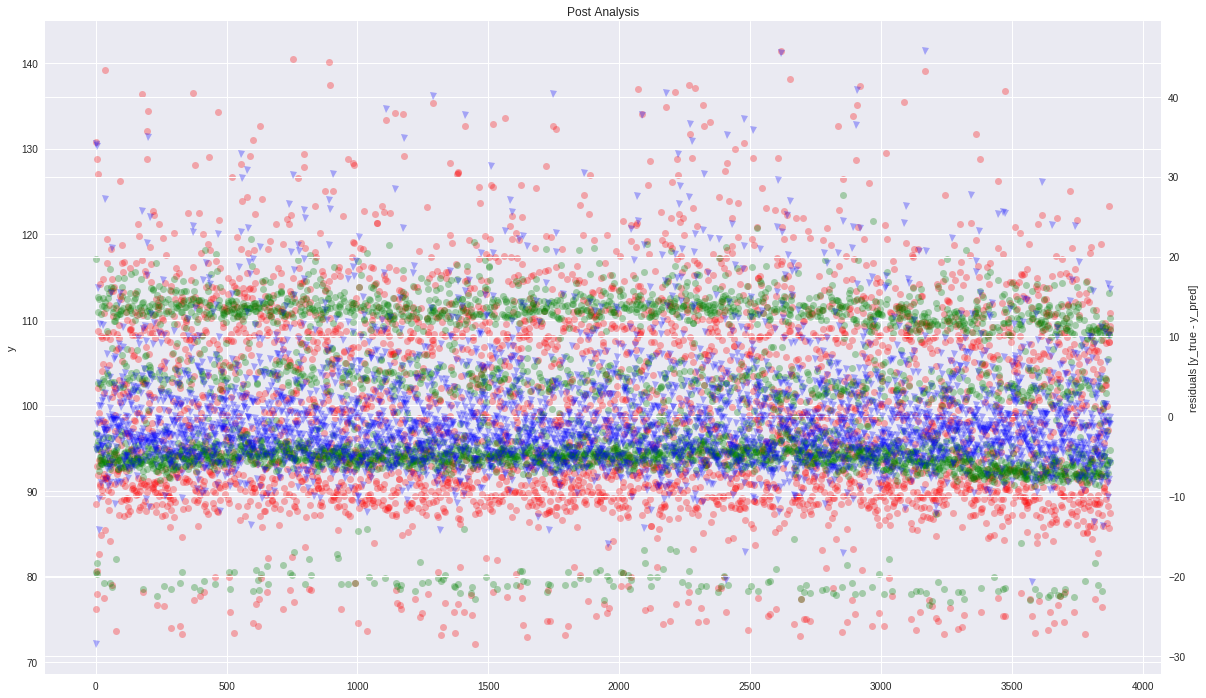

In [12]:
post_analysis = pd.DataFrame()
post_analysis['y_pred'] = dataset_blend_train
post_analysis['y_true'] = Y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

# graphing code
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.30)

ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

In [14]:
# Create submission file
submission_df = test_df[['ID']]
submission_df['y'] = dataset_blend_test.tolist()
submission_df.to_csv(os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'), index=False)
print('Generated submission ', os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'))

Generated submission  /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-1499378907.csv


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
